# Voting Revisited
#### Taking a look at Bayes and Logistic Regression 

##### TABLE OF CONTENTS
 - [Observations and Overview for Voting Revisited](#Observations-and-Overview-for-Voting-Revisited)
 - [Import and Define our Variables for Voting Revisited](#Import-and-Define-our-Variables-for-Voting-Revisited)
 - [Vectorizing X variables for Voting Revisited](#Vectorizing-X-variables-for-Voting-Revisited)
 - [Logistic Regression Model GridSearch (TFIDF)](#Logistic-Regression-Model-GridSearch-(TFIDF))
 - [Bayes Model GridSearch (TFIDF)](#Bayes-Model-GridSearch-(TFIDF))
 - [GridSearch Voting Ensemble with Logistic Regression + Naive Bayes ](#GridSearch-Voting-Ensemble-with-Logistic-Regression-+-Naive-Bayes)



### Observations and Overview for Voting Revisited
[(back to top)](#Voting-Revisited) <br />

After trying out lemmatization, I was interested whether there was anything that can make Naive Bayes perform better than my first (four) model(s) from the [03 - Models with GridSearch](03_models_with_gridsearch.ipynb) Notebook.

I found that a 0.4 weight for Naive Bayes and 0.6 weight for Logistic Regression gave the best results. While this improved bayes to an F1 Score of 0.669608 and made it slightly less biased, it made the Logistic Regression results a little worse. Like last time, I am find that it is not worth the trouble and time for a score that is almost the same as my less complicated Logistic Regression Model with TF-IDF Vectorization.


### Import and Define our Variables for Voting Revisited
[(back to top)](#Voting-Revisited) <br />



In [1]:
from ipynb.fs.full.functions import *


In [2]:
# Data to create our model
dfa = pd.read_csv('../data/ama_comments.csv')
dfb = pd.read_csv('../data/ar_comments.csv')
df = pd.concat([dfa, dfb], axis=0)
df = CleanUp(df).df.copy()

In [3]:
# Model X, and y
df = df.sample(n=df.shape[0], random_state=3)

X = df['body']
y = df['subreddit_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [4]:
# TEST data (not part of train/test/split)
df1 = pd.read_csv('../data/2021-04-27_1812_AMA_comments.csv')
df2 = pd.read_csv('../data/2021-04-27_1812_AskReddit_comments.csv')
df_test_pred = pd.concat([df1, df2], axis=0)
df_test_pred = CleanUp(df_test_pred).df.copy()

In [5]:
df_test_pred = df_test_pred.sample(n=df_test_pred.shape[0], random_state=3)

X_new = df_test_pred['body']
y_new = df_test_pred['subreddit_binary'] 

## Logistic Regression Model GridSearch (TFIDF)
[(back to top)](#Voting-Revisited) <br />



In [6]:

gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf LogReg')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [7]:

X_gs_tv_lgr = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    LogisticRegression()), 
    X_train=X, X_test=X_new, y_train=y, y_test=y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf LogReg')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


## Bayes Model GridSearch (TFIDF)
[(back to top)](#Voting-Revisited) <br />



In [8]:
gs_tv_nb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    MultinomialNB()), 
    X_train, X_test, y_train, y_test,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Train/Test Tfidf nBayes')



Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [9]:
X_gs_tv_nb = ClassificationModel(make_pipeline(
    TfidfVectorizer(), 
    MultinomialNB()), 
    X, X_new, y, y_new,
    params={
        'tfidfvectorizer__ngram_range': [ (1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3) ],
        'tfidfvectorizer__stop_words': [ 'english', None ],
        'tfidfvectorizer__max_features': [ 500, 1000, 2000, 5000 ]
}, verbose=3, mod_name='Xy/new Tfidf nBayes')


Fitting 5 folds for each of 48 candidates, totalling 240 fits


## GridSearch Voting Ensemble with Logistic Regression + Naive Bayes
[(back to top)](#Voting-Revisited) <br />



In [10]:
vote_lgr_gsbayes = VotingClassifier(
    [('gs_nb', gs_tv_nb.model), 
     ('lgr', gs_tv_lgr.model)],
    weights=[ 0.4, 0.6 ]
)

In [11]:
vote_lgr_gsbayes.fit_transform(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


array([[0, 0],
       [0, 0],
       [1, 1],
       ...,
       [0, 1],
       [1, 1],
       [1, 1]], dtype=int64)

In [12]:
y_pred_lgr_gsbayes = vote_lgr_gsbayes.predict(X_test)

f1_score(y_test, y_pred_lgr_gsbayes)

0.7275603005140372

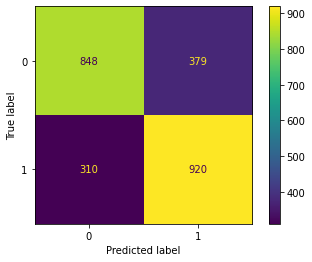

In [13]:
plot_confusion_matrix(vote_lgr_gsbayes, X_test, y_test)

In [14]:
vote_X_lgr_gsbayes = VotingClassifier(
    [('gs_nb', X_gs_tv_nb.model), 
     ('lgr', X_gs_tv_lgr.model)],
    weights=[ 0.4, 0.6 ]
)

In [15]:
vote_X_lgr_gsbayes.fit_transform(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


array([[0, 1],
       [1, 1],
       [0, 1],
       ...,
       [1, 1],
       [0, 0],
       [1, 1]], dtype=int64)

In [16]:
y_new_pred_lgr_gsbayes = vote_X_lgr_gsbayes.predict(X_new)

f1_score(y_new, y_new_pred_lgr_gsbayes)

0.6696078431372549

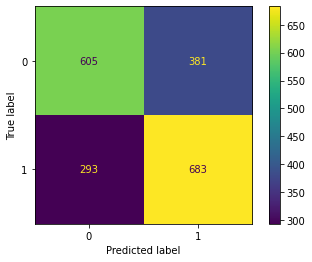

In [17]:
plot_confusion_matrix(vote_X_lgr_gsbayes, X_new, y_new)

In [18]:
print_classification_stats(y_new, y_new_pred_lgr_gsbayes)

{'F1 Score': 0.6696078431372549,
 'Recall Score': 0.6997950819672131,
 'Accuracy Score': 0.6564729867482161,
 'Balanced Accuracy': 0.6566926728294483,
 'Precision Score': 0.6419172932330827,
 'True Positive': 683,
 'False Negative': 293,
 'False Positive': 381,
 'True Negative': 605,
 'Calculated Accuracy': 0.6564729867482161,
 'Calculated Precision': 0.6419172932330827,
 'Calculated Sensitivity': 0.6997950819672131,
 'Calculated Specificity': 0.6135902636916836}

In [19]:
from sklearn.metrics import classification_report

In [20]:
print(classification_report(y_new, y_new_pred_lgr_gsbayes))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       986
           1       0.64      0.70      0.67       976

    accuracy                           0.66      1962
   macro avg       0.66      0.66      0.66      1962
weighted avg       0.66      0.66      0.66      1962

